In [11]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
from sympy import *
from scipy.stats import norm
from scipy.optimize import root

### 2. Data exercise: The volatility smile of the S&P 500.

In [12]:
# A Black-Scholes calculator.

def BS(S0, K, T, r, sigma, call = 1):
    d2 = (np.log(S0/K) + (r - sigma**2/2)*T)/(sigma*np.sqrt(T))
    d1 = d2 + sigma*np.sqrt(T)
    if call == 1:
        return S0*ss.norm.cdf(d1) - K*np.exp(-r*T)*ss.norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*ss.norm.cdf(-d2) - S0*ss.norm.cdf(-d1)

In [13]:
# An implied volatility calculator.

def IVOL(S0, K, T, r, MarketPrice, call = 1):
    def temp(v):
        return BS(S0, K, T, r, v, call) - MarketPrice
    res = root(temp,[2])
    # here the 2 is an initial guess for v of 200% vol. 
    return res.x[0]

,Dec,Mar
3000,0.194116,0.173924
3025,0.180119,0.168426
3050,0.165711,0.162756
3075,0.152082,0.157130
3100,0.136592,0.151326
3125,0.120000,0.145281
3150,0.102605,0.139215
3175,0.083892,0.133091
3200,0.009970,0.127253


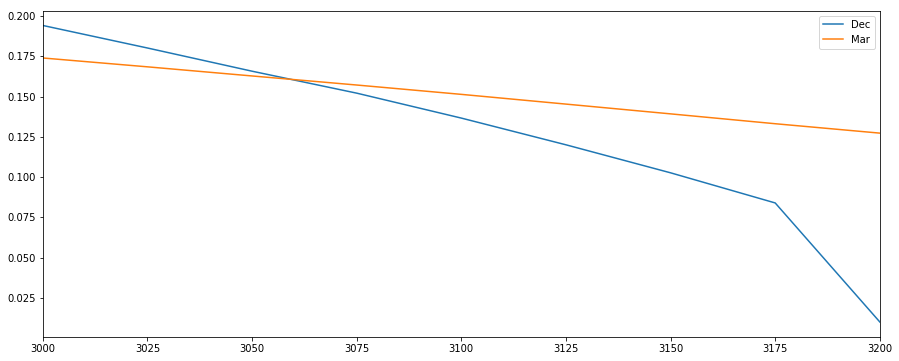

In [14]:
# d) 

SPX_Strike = [3000, 3025, 3050, 3075, 3100, 3125, 3150, 3175, 3200]
Dec = [3.6, 4.8, 6.5, 9.15, 12.85, 18.4, 27.1, 40.75, 59.95]
Mar = [53.6, 58.8, 64.5, 70.9, 77.95, 85.7, 94.4, 104.15, 115.3]

def continous(r):
    return np.log((1+r/2)**2)

Dec_V = []
for i, j in zip(SPX_Strike, Dec):
    Dec_V.append(IVOL(3139.50*np.exp(-continous(0.0154)*(1/36)), i, 1/36, continous(0.0154), j, call = 0))

Mar_V = []
for i, j in zip(SPX_Strike, Mar):
    Mar_V.append(IVOL(3142.00*np.exp(-continous(0.0157)*(17/63)), i, 17/63, continous(0.0157), j, call = 0))
    
IV1 = pd.DataFrame({"Dec": np.array(Dec_V), "Mar": np.array(Mar_V)}, index = list(SPX_Strike))

IV1.plot(figsize = (15, 6))
IV1

### 3. Data exercise: The volatility “smile” for Cell Therapeutics.

,Mar,Apr,Jun,Spe
5.0,3.346701,2.285177,1.616947,1.290433
7.5,3.293591,2.395247,1.678759,1.343442
10.0,3.473591,2.446994,1.704164,1.332004
12.5,3.555055,2.432393,1.666531,1.305330
15.0,3.403539,2.426227,1.621288,1.294746
17.5,3.360025,2.204365,1.539226,1.244429
20.0,3.208411,2.071739,1.527649,1.213701


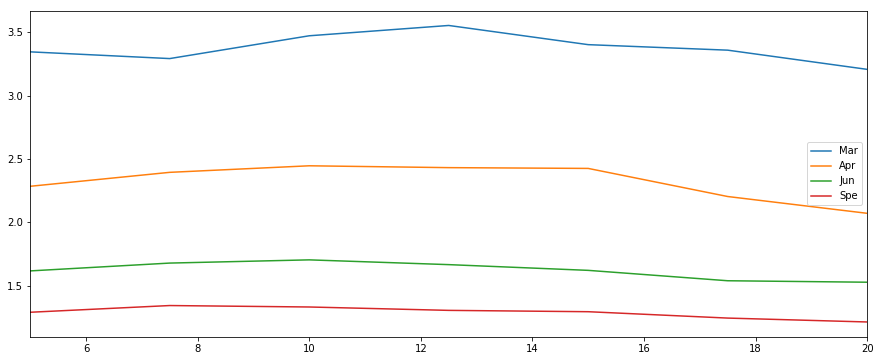

In [15]:
# b)

T_Mar = 10/252
T_Apr = 30/252
T_Jun = 74/252
T_Sep = 137/252
Strike = [5, 7.5, 10, 12.5, 15, 17.5, 20]
put_Mar = [0.35, 1.2, 2.7, 4.5, 6.35, 8.45, 10.6]
put_Apr = [0.55, 1.7, 3.25, 5, 6.95, 8.75, 10.8]
put_Jun = [0.7, 1.925, 3.5, 5.2, 7.05, 8.95, 11.1]
put_Sep = [0.825, 2.125, 3.65, 5.35, 7.25, 9.15, 11.2]

IV_Mar = []
for i, j in zip(Strike, put_Mar):
    IV_Mar.append(IVOL(10, i, T_Mar, continous(0.0256), j, call = 0))

IV_Apr = []
for i, j in zip(Strike, put_Apr):
    IV_Apr.append(IVOL(10, i, T_Apr, continous(0.0266), j, call = 0))

IV_Jun = []
for i, j in zip(Strike, put_Jun):
    IV_Jun.append(IVOL(10, i, T_Jun, continous(0.0292), j, call = 0))

IV_Sep = []
for i, j in zip(Strike, put_Sep):
    IV_Sep.append(IVOL(10, i, T_Sep, continous(0.0317), j, call = 0))
    
IV2 = pd.DataFrame({"Mar": np.array(IV_Mar),
                    "Apr": np.array(IV_Apr), 
                    "Jun": np.array(IV_Jun),
                    "Spe": np.array(IV_Sep)}, 
                   index = list(Strike))

IV2.plot(figsize = (15, 6))
IV2

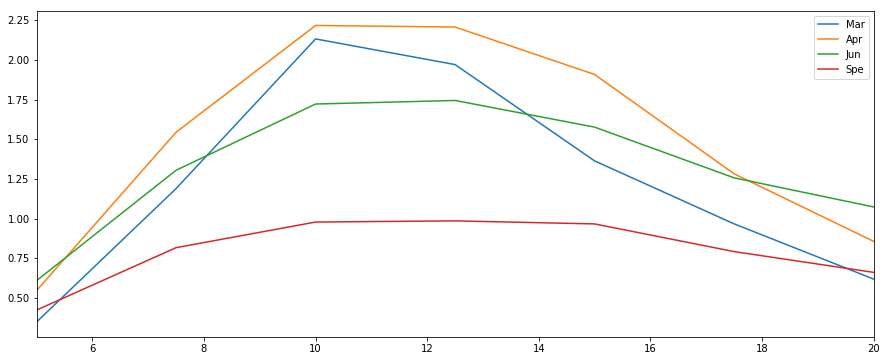

In [16]:
# d)

def Adj_Var(T):
    return np.sqrt(0.9**2+0.7**2/T)*np.sqrt(T)

MP_Mar = []
for k in Strike:
    MP_Mar.append(BS(10, k, T_Mar, continous(0.0256), Adj_Var(T_Mar), call = 0))

MP_Apr = []
for k in Strike:
    MP_Apr.append(BS(10, k, T_Apr, continous(0.0266), Adj_Var(T_Apr), call = 0))

MP_Jun = []
for k in Strike:
    MP_Jun.append(BS(10, k, T_Jun, continous(0.0292), Adj_Var(T_Jun), call = 0))

MP_Sep = []
for k in Strike:
    MP_Sep.append(BS(10, k, T_Sep, continous(0.0317), Adj_Var(T_Sep), call = 0))

difference = pd.DataFrame({"Mar": np.array(put_Mar)-np.array(MP_Mar),
                           "Apr": np.array(put_Apr)-np.array(MP_Apr), 
                           "Jun": np.array(put_Jun)-np.array(MP_Jun),
                           "Spe": np.array(put_Sep)-np.array(MP_Sep)}, 
                          index = list(Strike))

difference.plot(figsize = (15, 6))

### 4. Python exercise: Using Monte Carlo to price options in a jump-diffusion model.

In [7]:
# b)

def MC_StockPrice(S0, r, sigma, crash_rate, crash_loss, crash_sigma, T, N):
    X = np.random.normal(0,1,N)
    r_diffusive = (r - sigma**2/2 + crash_rate*crash_loss)*T + sigma*np.sqrt(T)*X
    jumps = np.random.poisson(crash_rate*T, N)
    r_jump = jumps*np.log(1 - crash_loss) + np.random.normal(-jumps*crash_sigma**2/2, np.sqrt(jumps)*crash_sigma)
    ST = S0*np.exp(r_diffusive+r_jump)
    return ST

In [8]:
MC_StockPrice(100, 0.05, 0.50, 0.1, 0.2, 0.3, 1, 1000000).mean()*np.exp(-0.05*1)

100.10079946164511

In [9]:
# c) 

def OptionPrice(S0, r, sigma, crash_rate, crash_loss, crash_sigma, T, N, K, call = 1):
    nPrice = MC_StockPrice(S0, r, sigma, crash_rate, crash_loss, crash_sigma, T, N)
    nPayoff = []
    if call == 1:
        for s in nPrice:
            nPayoff.append(max(s-K, 0))
    else:
        for s in nPrice:
            nPayoff.append(max(K-s, 0))
    return (np.array(nPayoff).mean())*np.exp(-r*T)

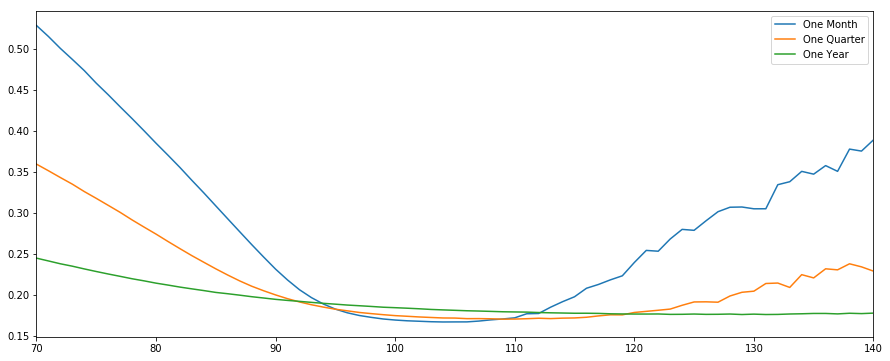

In [10]:
# d) 

put_one_month = []
for k in np.arange(70, 141, 1):
    put_one_month.append(OptionPrice(100, 0.02, 0.16, 0.1, 0.2, 0.3, 1/12, 10000000, k, call = 0))
IV_one_month = []
for i, j in zip(np.arange(70, 141, 1), put_one_month):
    IV_one_month.append(IVOL(100, i, 1/12, 0.02, j, call = 0))

put_one_quarter = []
for k in np.arange(70, 141, 1):
    put_one_quarter.append(OptionPrice(100, 0.02, 0.16, 0.1, 0.2, 0.3, 1/4, 10000000, k, call = 0))
IV_one_quarter = []
for i, j in zip(np.arange(70, 141, 1), put_one_quarter):
    IV_one_quarter.append(IVOL(100, i, 1/4, 0.02, j, call = 0))

put_one_year = []
for k in np.arange(70, 141, 1):
    put_one_year.append(OptionPrice(100, 0.02, 0.16, 0.1, 0.2, 0.3, 1, 10000000, k, call = 0))
IV_one_year = []
for i, j in zip(np.arange(70, 141, 1), put_one_year):
    IV_one_year.append(IVOL(100, i, 1, 0.02, j, call = 0))
    
IV3 = pd.DataFrame({"One Month": np.array(IV_one_month),
                    "One Quarter": np.array(IV_one_quarter), 
                    "One Year": np.array(IV_one_year)}, 
                    index = list(np.arange(70, 141, 1)))

IV3.plot(figsize = (15, 6))